# Milestone 10
## Descorrelación espacial en señales de audio estéreo

Como especifica el [enunciado](https://tecnologias-multimedia.github.io/study_guide/spatial_decorrelation/), usaremos el código del [notebook](https://tecnologias-multimedia.github.io/study_guide/spatial_decorrelation/), añadiéndole mejoras



## - Decorrelacionar:

Fórmula facilitada:

· $w_{0} = x_{0} + x_{1}$

· $w_{1} = x_{0} - x_{1}$



In [22]:
def MST_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = x[:, 0].astype(np.int32) + x[:, 1] # L(ow frequency subband)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1] # H(igh frequency subband)
    return w

### PROBLEMA ![Alert](https://i.imgur.com/n2guntp.png)
Necesitamos almacenar los datos en un tipo int32, es decir, el doble de lo que realmente se necesita para que no desborde.

### SOLUCIÓN ![Solution](https://i.imgur.com/byb4mnc.png)
Como queremos mejorar la compresión y el número de bits que se envían, vamos a almacenarlo como un int16 ¿cómo hacer para que no desborde? Disminuyendo la amplitud de las señales de la siguiente forma:

· $w_{0} = \frac{1}{2}(x_{0} + x_{1})$

· $w_{1} = \frac{1}{2}(x_{0} - x_{1})$

In [23]:
def MST_analyze_Mejorado(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = (x[:, 0].astype(np.int32) + x[:, 1])//2 # L(ow frequency subband)
    w[:, 1] = (x[:, 0].astype(np.int32) - x[:, 1])//2 # H(igh frequency subband)
    return w.astype(np.int16) # Lo convertimos a int16

## - Correlacionar
Facilitado por el profesor:

· $w_{0} = \frac{1}{2}(x_{0} + x_{1})$

· $w_{1} = \frac{1}{2}(x_{0} - x_{1})$

In [24]:
def MST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = (w[:, 0] + w[:, 1])/2 # L(ow frequency subband)
    x[:, 1] = (w[:, 0] - w[:, 1])/2 # H(igh frequency subband)
    return x

Nuestras fórmulas ![star](https://i.imgur.com/FKwm0ue.png)

· $w_{0} = x_{0} + x_{1}$

· $w_{1} = x_{0} - x_{1}$

In [25]:
def MST_synthesize_Mejorado(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = w[:, 0] + w[:, 1] # L(ow frequency subband)
    x[:, 1] = w[:, 0] - w[:, 1] # H(igh frequency subband)
    return x

## Prueba ![test](https://i.imgur.com/djhYERu.png)

In [94]:
import sounddevice as sd
import numpy as np
fs = 44100
duration = 3.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype=np.int16)
print("Habla!")
while sd.wait():
    pass
print("Hecho")

Habla!
Hecho


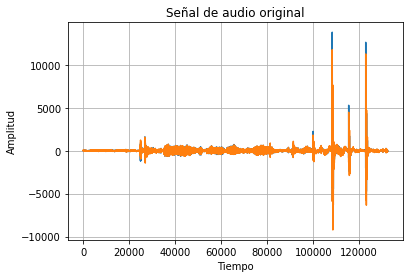

In [96]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import math

def plot(x, *args, xlabel='', ylabel='', title='', ylim=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    if ylim:
        ax.set_ylim([-ylim, ylim])
    ax.plot(x, *args)
    plt.show(block=False)

plot(np.linspace(0, len(x)-1, len(x)), x[:,0], x[:,1], xlabel="Tiempo", ylabel="Amplitud", title="Señal de audio original")

## Comparación de las señales ![compare](https://i.imgur.com/LkwsSoI.png): 


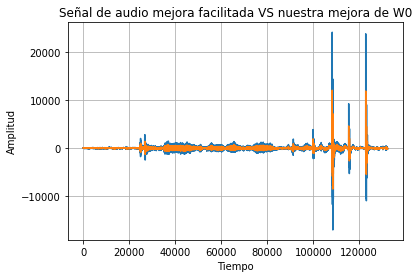

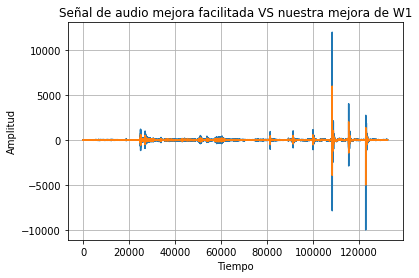

In [97]:
y = MST_analyze(x) # Fórmula facilitado
z = MST_analyze_Mejorado(x) # Fórmula mejorada

plot(np.linspace(0, len(x)-1, len(x)), y[:,0], z[:,0], xlabel="Tiempo", ylabel="Amplitud", title="Señal de audio mejora facilitada VS nuestra mejora de W0")
plot(np.linspace(0, len(x)-1, len(x)), y[:,1], z[:,1], xlabel="Tiempo", ylabel="Amplitud", title="Señal de audio mejora facilitada VS nuestra mejora de W1")

## Reconstruimos la señal ![compare](https://i.imgur.com/LkwsSoI.png)

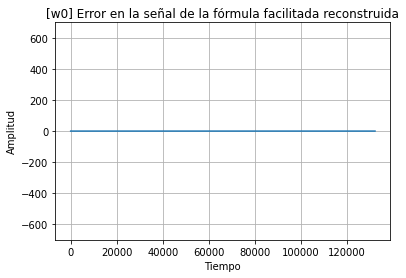

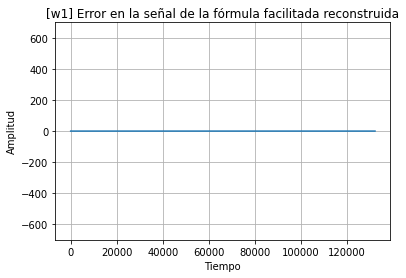

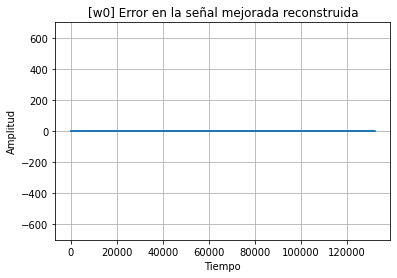

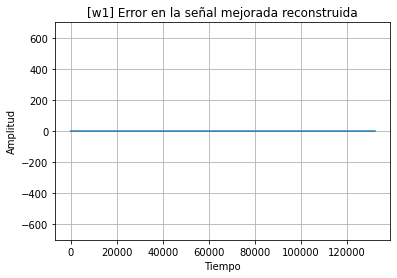

In [98]:
sy = MST_synthesize(y) # Fórmula facilitada
sz = MST_synthesize_Mejorado(z) # Fórmula mejorada

plot(np.linspace(0, len(x)-1, len(x)), sy[:,0]-x[:,0], xlabel="Tiempo", ylabel="Amplitud", title="[w0] Error en la señal de la fórmula facilitada reconstruida", ylim=700)
plot(np.linspace(0, len(x)-1, len(x)), sy[:,1]-x[:,1], xlabel="Tiempo", ylabel="Amplitud", title="[w1] Error en la señal de la fórmula facilitada reconstruida", ylim=700)

plot(np.linspace(0, len(x)-1, len(x)), sz[:,0]-x[:,0], xlabel="Tiempo", ylabel="Amplitud", title="[w0] Error en la señal mejorada reconstruida", ylim=700)
plot(np.linspace(0, len(x)-1, len(x)), sz[:,1]-x[:,1], xlabel="Tiempo", ylabel="Amplitud", title="[w1] Error en la señal mejorada reconstruida", ylim=700)

In [47]:
print(f"El rango de valores de la señal puede ir desde -32768 hasta 32767 aprox (int16). y tiene un error despreciable de {np.max(sz[:,0]-x[:,0]) - np.min(sz[:,0]-x[:,0])}, esto se debe a la división en analyze(x)")

El rango de valores de la señal puede ir desde -32768 hasta 32767 aprox (int16). y tiene un error despreciable de 1, esto se debe a la división en analyze(x)


# ¿Qué hemos conseguido con esto?

Hemos conseguido aumentar el ratio de compresión. Esto se debe a que, con el código proporcionado, los datos de audio pasaban de almacenarse como int16 (en prácticas anteriores) a almacenarse como int32. Esto duplica la memoria que ocupan los datos de audio, y, aunque el algoritmo de compresión consigue reducir bastante el tamaño de los paquetes, no los reduce tanto como cuando se le pasan los datos ocupando la mitad de espacio en int16.

![happy](https://i.imgur.com/yKrGkGA.png)

# RESULTADOS DE COMPRESIÓN
![comparación de la compresión](https://i.imgur.com/4ywP7dE.jpg)

Hemos hecho que `quantization_step` valga 1 para que la compresión que se muestre sea únicamente de la nueva implementación

· En Mono mejora un 13% y en stereo un 10%

In [130]:
def average_energy(x):
    #return np.sum(x[:, 0].astype(np.double)*x[:, 0].astype(np.double))/len(x[:, 0]) + \
    #       np.sum(x[:, 1].astype(np.double)*x[:, 1].astype(np.double))/len(x[:, 1])
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)
    
def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

# Based on https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python
def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

def deadzone_quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int)
    return k

def deadzone_dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def deadzone_qdeq(x, quantization_step):
    k = deadzone_quantizer(x, quantization_step)
    y = deadzone_dequantizer(k, quantization_step)
    return k, y

def RD_curve(chunk, analyze, synthesize):
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_chunk = analyze(chunk)
        k, y = deadzone_qdeq(analyzed_chunk, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        reconstructed_chunk = synthesize(y)
        distortion = RMSE(chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
    return RD_points

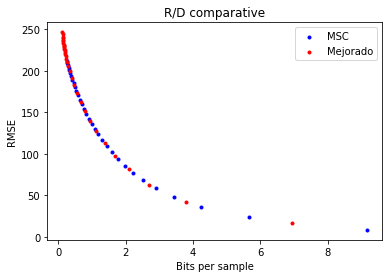

In [127]:
MST_RD_points = RD_curve(x, MST_analyze, MST_synthesize)
MST_RD_points_Mejorado = RD_curve(x, MST_analyze_Mejorado, MST_synthesize_Mejorado)

plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MST_RD_points), c='b', marker=".", label='MSC')
plt.scatter(*zip(*MST_RD_points_Mejorado), c='r', marker=".", label='Mejorado')
plt.legend(loc='upper right')
plt.show()

Con `quantization_step = 1`


![](https://i.imgur.com/rJuGOMD.jpg)